In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn
from IPython.display import display, Audio
import librosa
from tqdm import tqdm
import pytsmod
from src import timewarp

seaborn.set_theme()

In [15]:
x, FS = librosa.load(
    "datasets/unmixdb-zenodo/mixotic-set275-excerpts/refsongs/03_F.l.o._-_Tegula.excerpt40.mp3",
    mono=True,
    offset=1,
    duration=5,
    sr=8000,
)
t = np.arange(len(x)) / FS
display(Audio(x, rate=FS))
print(FS)

8000


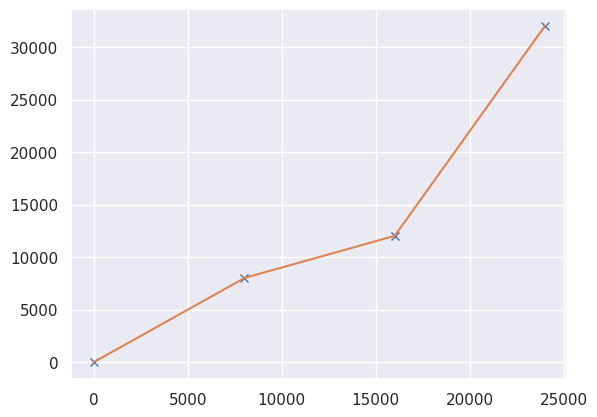

In [16]:
# control_points = np.array([[0, 0], [1, 1], [1, 0], [3, 0.5]]).T
control_points = np.array([[0, 0], [1, 1], [2, 1.5], [3, 4]]).T
control_points *= FS

idx = np.arange(int(control_points.max(axis=1)[0]))
new_indices = np.interp(idx, control_points[0], control_points[1])
plt.plot(*control_points, "x")
plt.plot(idx, new_indices)

100%|██████████| 24000/24000 [00:01<00:00, 23898.01it/s]


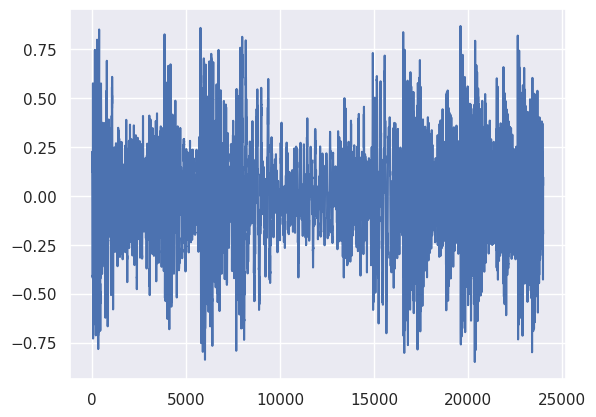

In [35]:
y = timewarp.resample_fast(x, new_indices)
plt.plot(y)
display(Audio(y, rate=FS))

import soundfile as sf

sf.write("x.wav", x, FS)
sf.write("y.wav", y, FS)

(24000,)
(23501, 500)


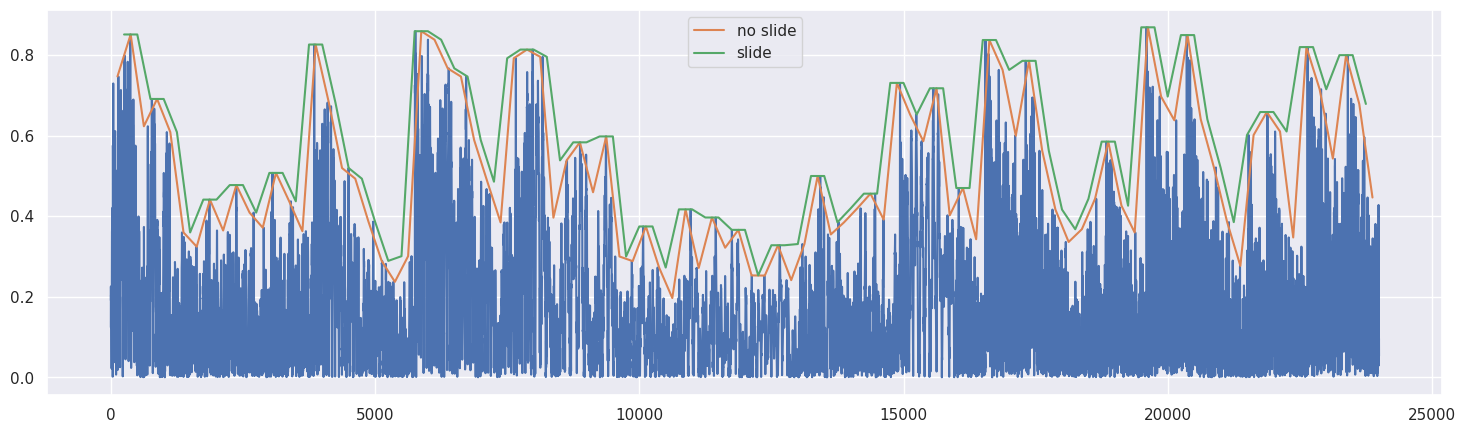

In [68]:
import scipy.ndimage


def envelope(x: np.ndarray, wlen=10, ufunc=np.maximum):
    indices = np.r_[: len(x) : wlen]
    env = np.maximum.reduceat(abs(x), indices)
    t_env = indices + wlen // 2
    return t_env, env


def envelope_sliding(x, wlen, stride, ufunc=np.maximum):
    v = np.lib.stride_tricks.sliding_window_view(
        abs(x),
        wlen,
    )
    print(x.shape)
    print(v.shape)
    env = ufunc.reduce(v[::stride], axis=1).T
    t_env = np.r_[: v.shape[0] : stride] + wlen // 2
    return t_env, env


plt.figure(figsize=(18, 5))
plt.plot(idx, abs(y))
t_env, env = envelope(y, 250)
plt.plot(t_env, env, label="no slide")
plt.plot(*envelope_sliding(y, 500, 250), label="slide")
plt.legend()

In [1]:
import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



(24000,)
(23951, 50)
(40000,)
(39951, 50)
DTW alignment object of size (query x reference): 959 x 1599 69.21249816297562


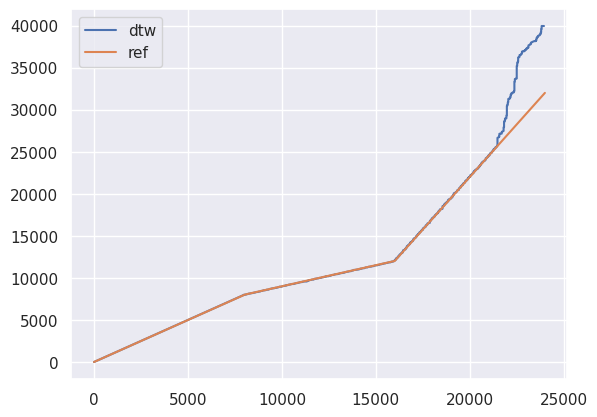

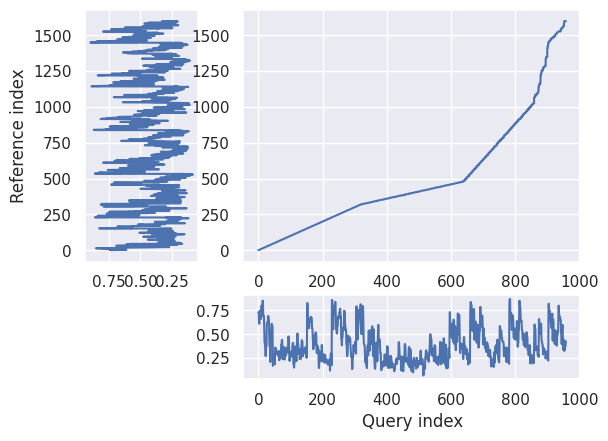

In [78]:
wlen = 50
y_offset = int(0 * FS)
x_offset = int(0.1 * FS)

env_t, query = envelope_sliding(y, wlen, wlen//2)
_, reference = envelope_sliding(x, wlen, wlen//2)
r = dtw.dtw(query, reference, step_pattern="symmetric2")
print(r, r.distance)
plt.plot(r.index1 * wlen//2, r.index2 * wlen//2, label="dtw")
plt.plot(new_indices, label="ref")
plt.legend()
plt.show()
r.plot(type="threeway", xts=query, yts=reference)
plt.show()